In [1]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# class LinearRegression:
#     def __init__(self, n_covariates):
#         #stdv = 1. / np.sqrt(out_len)
#         stdv = 1.
#         self.w = np.random.uniform(-stdv, stdv, (n_covariates, 1))
#         self.b = np.array([[0 + 1e-5]])
#         #self.w = np.random.randn(in_len, out_len)
        
#     def __call__(self, x):
#         self.x = x
#         return self.b + (x @ self.w)
        
#     def backward(self, loss_grad):
#         self.w_grad = loss_grad @ self.x
#         self.b_grad = loss_grad
        
#     def clear_grad(self):
#         self.x = None
#         self.w_grad = None
#         self.b_grad = None
    
# loss_func = lambda y_t, y: (y_t - y)**2  # squared error
# loss_grad = lambda y_t, y: 2*(y - y_t)

# model = LinearRegression(n_covariates)

# n_epochs = 10
# lr = 0.03

# for step in range(n_epochs):
#     total_loss = 0
#     for (x, y) in zip(X_data, y_data):
#         x = np.expand_dims(x, 0)
#         y = np.expand_dims(y, 0)
#         model.clear_grad()
#         out = model(x)
#         total_loss += loss_func(y, out)
#         model.backward(loss_grad(y, out))
#         model.w -= lr * model.w_grad.T
#         model.b -= lr * model.b_grad
        
#     print(f'epoch: {step}, total loss: {total_loss}')

### 1. Study of outliers

- large outliers, but few and one sided
- large outliers on both sides
- outliers in the middle?

#### 1. Create linear dataset



In [3]:
n_samples, n_covariates = 1000, 50

X_data = np.random.randn(n_samples, n_covariates)
y_data = X_data @ np.linspace(0, 1, n_covariates)

#### 2. Create linear regression model and benchmark

In [4]:
model = LinearRegression()    
model.fit(X_data, y_data)

predictions = model.predict(X_data)
print('Mean Squared Error: ', np.mean((predictions - y_data) ** 2))
print('coefficients:')
print('mean: ',np.mean(model.coef_))
print('standard deviation: ', np.std(model.coef_))
print('error score: ', np.sum(predictions - y_data))

Mean Squared Error:  3.9132248894054083e-29
coefficients:
mean:  0.5
standard deviation:  0.294507544686976
error score:  -1.6579793093995931e-13


As we can see the model fits well with low error and good distribution of coefficients with low deviation

### 1. introducing large outliers

In [5]:
n_samples, n_covariates = 1000, 50

X_data = np.random.randn(n_samples, n_covariates)
y_data = X_data @ np.linspace(0, 1, n_covariates)

y_data[0:10] *= 1000
model = LinearRegression()    
model.fit(X_data, y_data)

predictions = model.predict(X_data)
print('Mean Squared Error: ', np.mean((predictions - y_data) ** 2))
print('coefficients:')
print('mean: ',np.mean(model.coef_))
print('standard deviation: ', np.std(model.coef_))
print('error score: ', np.sum(predictions - y_data))

Mean Squared Error:  85573.29606783939
coefficients:
mean:  5.2290734444185345
standard deviation:  7.51165937762507
error score:  -3.637978807091713e-12


As we can see, increasing the magnitude of ten random samples by 1000 has greatly increased the mean squared error of our model and the standard deviation of coefficients, yet our error score is still good.  This shows that even as we have found a line of best fit, where data points are equally spread on either side, the distance between each point and the line is large.

Below we can see the results of varying the amount of outliers

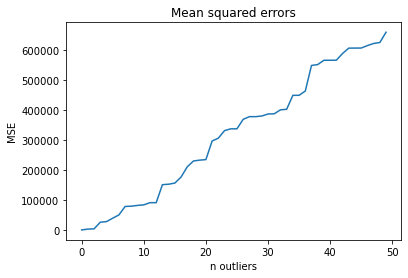

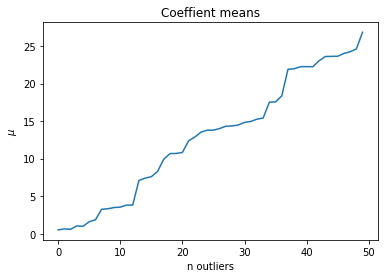

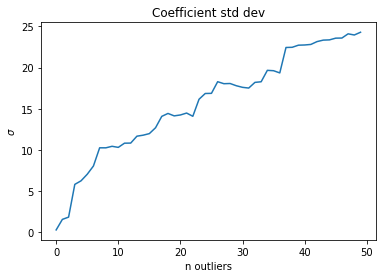

In [6]:
errors = []
means = []
stds = []

for i in range (50):
    np.random.seed(10)
    n_samples, n_covariates = 1000, 50

    X_data = np.random.randn(n_samples, n_covariates)
    y_data = X_data @ np.linspace(0, 1, n_covariates)

    y_data[0:i] *= 1000
    model = LinearRegression()    
    model.fit(X_data, y_data)

    predictions = model.predict(X_data)
    errors.append(np.mean((predictions - y_data) ** 2))
    means.append(np.mean(model.coef_))
    stds.append(np.std(model.coef_))
    
plt.plot(errors)
plt.title('Mean squared errors')
plt.xlabel('n outliers')
plt.ylabel('MSE')
plt.show()
plt.plot(means)
plt.title('Coeffient means')
plt.xlabel('n outliers')
plt.ylabel(r'$\mu$')
plt.show()
plt.plot(stds)
plt.title('Coefficient std dev')
plt.xlabel('n outliers')
plt.ylabel(r'$\sigma$')
plt.show()

Below we can see the results of varying the magnitude of outliers.  This shows us that, while there are more outliers than the previous experiment, the fact that they were a lower magnitude produced less variance in the results

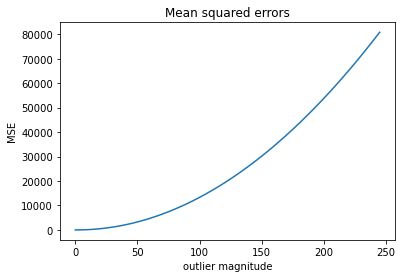

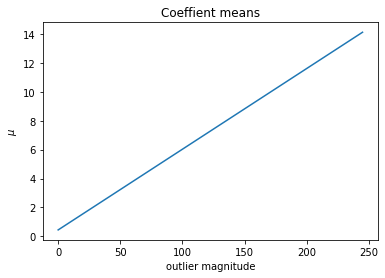

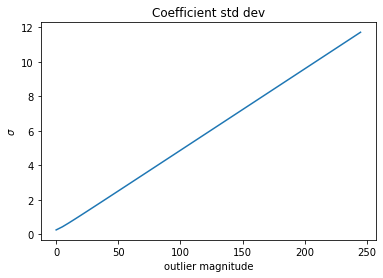

In [7]:
errors = []
means = []
stds = []

for i in range (50):
    np.random.seed(10)
    n_samples, n_covariates = 1000, 50

    X_data = np.random.randn(n_samples, n_covariates)
    y_data = X_data @ np.linspace(0, 1, n_covariates)

    y_data[0:100] *= i*5
    model = LinearRegression()    
    model.fit(X_data, y_data)

    predictions = model.predict(X_data)
    errors.append(np.mean((predictions - y_data) ** 2))
    means.append(np.mean(model.coef_))
    stds.append(np.std(model.coef_))
    
plt.plot(list([i*5 for i in range(len(errors))]),errors)
plt.title('Mean squared errors')
plt.xlabel('outlier magnitude')
plt.ylabel('MSE')
plt.show()
plt.plot(list([i*5 for i in range(len(means))]),means)
plt.title('Coeffient means')
plt.xlabel('outlier magnitude')
plt.ylabel(r'$\mu$')
plt.show()
plt.plot(list([i*5 for i in range(len(stds))]),stds)
plt.title('Coefficient std dev')
plt.xlabel('outlier magnitude')
plt.ylabel(r'$\sigma$')
plt.show()

### Removal techniques for outliers:
#### 1. Z-score thresholding
If the absolute average z-score across all covariates for a sample $| \frac{1}{n}\sum_{i}^{n}\frac{(x_{i,i} - \mu_i)}{\sigma_i} |$ is greater than a certain threshold, remove it.


1.3322676295501879e-18
0.13669204859891781


0

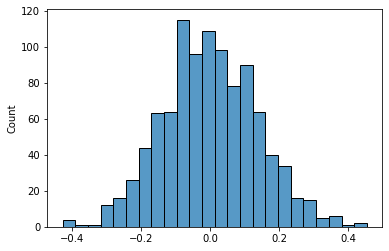

In [8]:
np.random.seed(10)
n_samples, n_covariates = 1000, 50

X_data = np.random.randn(n_samples, n_covariates)
y_data = X_data @ np.linspace(0, 1, n_covariates)

means = np.mean(X_data, axis=0)
stds = np.std(X_data, axis=0)

Z_scores = np.mean((X_data - means) / stds, axis=1)
print(np.mean(Z_scores))
print(np.std(Z_scores))
sns.histplot(Z_scores)
(np.abs(Z_scores) > 0.5).sum()

As we can see, for our cleanly formatted data there are no datapoints where this condition is true, leading to the assumption that we have no outliers

-6.439293542825908e-18
0.12310205828335391


5

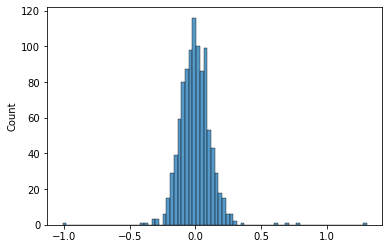

In [9]:
np.random.seed(10)
n_samples, n_covariates = 1000, 50
X_data = np.random.randn(n_samples, n_covariates)
y_data = X_data @ np.linspace(0, 1, n_covariates)

X_data[0:10] *= 10
means = np.mean(X_data, axis=0)
stds = np.std(X_data, axis=0)

Z_scores = np.mean((X_data - means) / stds, axis=1)
print(np.mean(Z_scores))
print(np.std(Z_scores))
sns.histplot(Z_scores)

(np.abs(Z_scores) > 0.5).sum()

As we can see, setting a threshold of 0.5 has eliminated five datapoints, which accounts for half of the added outliers.

### 2. Study of normalization

### 1. Create data

In [42]:
np.random.seed(10)
n_samples, n_covariates = 1000, 50
X_data = np.random.randn(n_samples, n_covariates)
y_data = X_data @ np.linspace(0, 1, n_covariates)

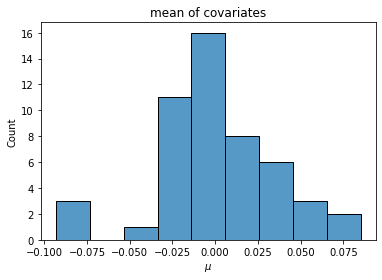

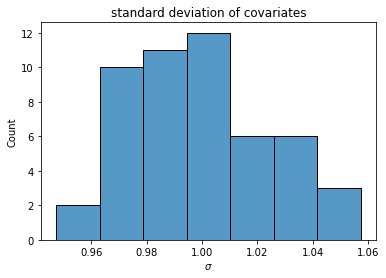

In [43]:
means = np.mean(X_data, axis=0)
stds = np.std(X_data, axis=0)

sns.histplot(means)
plt.title('mean of covariates')
plt.xlabel(r'$\mu$')
plt.show()
sns.histplot(stds)
plt.title('standard deviation of covariates')
plt.xlabel(r'$\sigma$')
plt.show()

As we can see above, our nice data is already nicely distributed, so we need to now add some random noise otherwise normalization will have no effect.

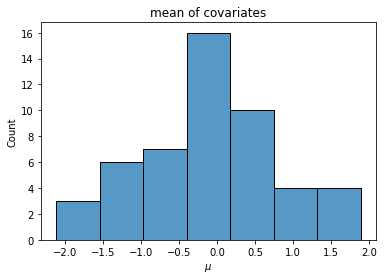

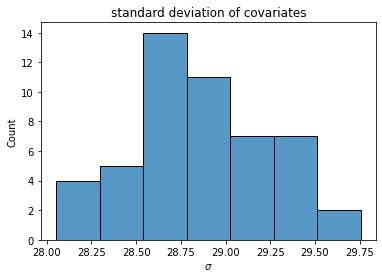

In [44]:
np.random.seed(10)
n_samples, n_covariates = 1000, 50
X_data = np.random.randn(n_samples, n_covariates)
X_data += (np.random.rand(n_samples, n_covariates) * 100 - 50)
y_data = X_data @ np.linspace(0, 1, n_covariates)
means = np.mean(X_data, axis=0)
stds = np.std(X_data, axis=0)

sns.histplot(means)
plt.title('mean of covariates')
plt.xlabel(r'$\mu$')
plt.show()
sns.histplot(stds)
plt.title('standard deviation of covariates')
plt.xlabel(r'$\sigma$')
plt.show()

### Linear regression analysis

Now we run linear regression on the new noisy data taking note of the mean squared error and error scores.  We then compare this to other linear regressions run on the data with a variety of standardization and normalization techniques applied.

In [47]:
# Noisy data
np.random.seed(10)
n_samples, n_covariates = 1000, 50
X_data = np.random.randn(n_samples, n_covariates)
X_data += (np.random.rand(n_samples, n_covariates) * 100 - 50)
y_data = X_data @ np.linspace(0, 1, n_covariates)

model = LinearRegression()    
model.fit(X_data, y_data)
print('MSE: ',np.mean((predictions - y_data) ** 2))
print('Error score: ', np.sum(model.predict(X_data) - y_data))

MSE:  28937.188198671527
Error score:  -3.321426467195465e-12


We have a high mean squared error but an optimal line of best fit, this means that the quality of our predictions will always be suboptimal.

Let's evaluate the effect of normalization:

MSE:  28937.188198671527
Error score:  -4.0326353367703405e-12


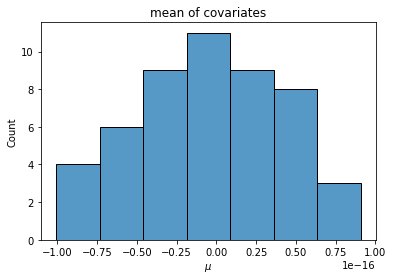

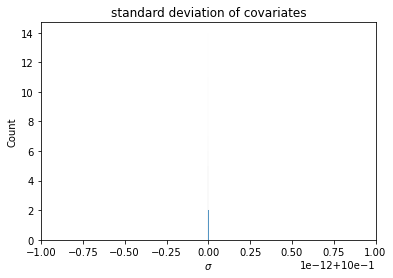

In [53]:
# Noisy data
np.random.seed(10)
n_samples, n_covariates = 1000, 50
X_data = np.random.randn(n_samples, n_covariates)
X_data += (np.random.rand(n_samples, n_covariates) * 100 - 50)
y_data = X_data @ np.linspace(0, 1, n_covariates)

means = np.mean(X_data, axis=0)
stds = np.std(X_data, axis=0)

X_data = (X_data - means) / stds

model = LinearRegression()    
model.fit(X_data, y_data)
print('MSE: ', np.mean((predictions - y_data) ** 2))
print('Error score: ', np.sum(model.predict(X_data) - y_data))

means = np.mean(X_data, axis=0)
stds = np.std(X_data, axis=0)

sns.histplot(means)
plt.title('mean of covariates')
plt.xlabel(r'$\mu$')
plt.show()
sns.histplot(stds)
plt.title('standard deviation of covariates')
plt.xlabel(r'$\sigma$')
plt.show()

As we can see above, the normalized data fits the normal distrubution and has little standard deviation, however the training metrics are unimproved over the non-normalized data.  Therefore, we can conclude that normalization will not help linear regression performance on data with noisy values.